In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.ticker as ticker
import sys

import torch
torch.cuda.set_device(1)



sys.path.insert(0, '/home/shenwanxiang/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, plot_performance, score2
from compass.tokenizer import CANCER_CODE

/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mfile = '../../checkpoint/latest/pretrainer.pt'
pretrainer = loadcompass(mfile)

data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))

df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))[pretrainer.feature_name]
df_tpm.shape, df_label.shape

((1133, 15672), (1133, 110))

In [3]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfgeneset, dfcelltype = pretrainer.extract(dfcx, batch_size=16)
dfg_feat, dfc_feat = pretrainer.project(dfcx, batch_size=16)

100%|###################################################################################| 71/71 [00:04<00:00, 15.62it/s]


## Do a Correction for differences in T cell infiltration between samples

In [15]:
expression = np.log10(df_tpm + 1)
ref = ['CD3E', 'CD3D', 'CD3E'] #ACTB','HNRNPK','HNRNPU','SNRPD3','SRRM1','ZNF207
n = expression[ref].mean(axis=1)
df_tpm_norm = expression.apply(lambda x: x-n, axis=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
df_tpm_norm = scaler.fit_transform(df_tpm_norm)
dfcx_norm = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm_norm)

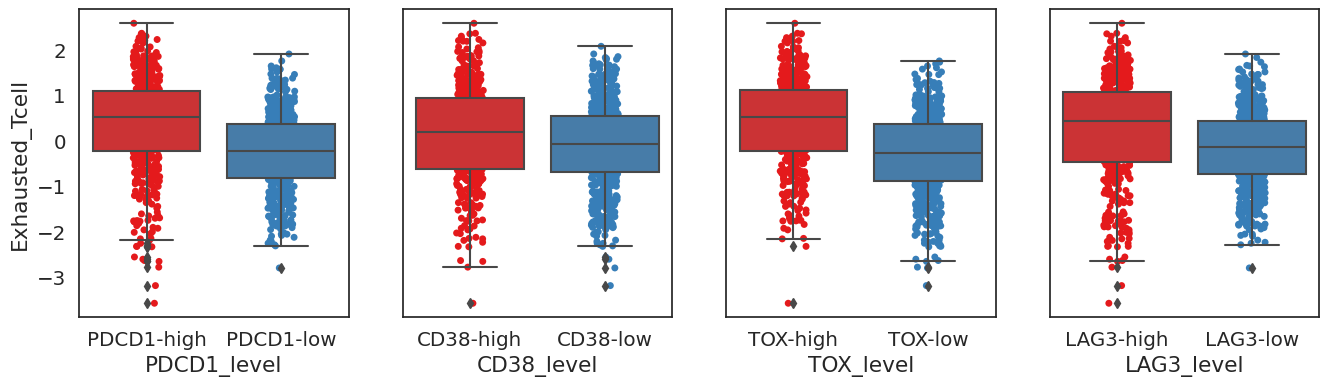

In [16]:

fig, axes=plt.subplots(figsize=(16,4),  nrows=1, ncols=4, sharey=True)

for y,ax in zip(['PDCD1', 'CD38', 'TOX', 'LAG3'], axes):
    dfp = dfcelltype[['Exhausted_Tcell']].join(np.log10(dfcx_norm[y]+1))
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
    dfp = scaler.fit_transform(dfp)
    median_value = dfp[y].median()
    # Create a new column 'CD38_category' to categorize the rows as 'CD38-high' or 'CD38-low'
    dfp['%s_level' % y] = ['%s-high' % y if x >= median_value else '%s-low' % y for x in dfp[y]]

    sns.stripplot(data = dfp, x='%s_level' % y, y = 'Exhausted_Tcell', order = ['%s-high' % y, '%s-low' % y], ax=ax, zorder = 0.5, palette='Set1')
    sns.boxplot(data = dfp, x='%s_level' % y, y = 'Exhausted_Tcell', order = ['%s-high' % y, '%s-low' % y], ax=ax, palette='Set1')


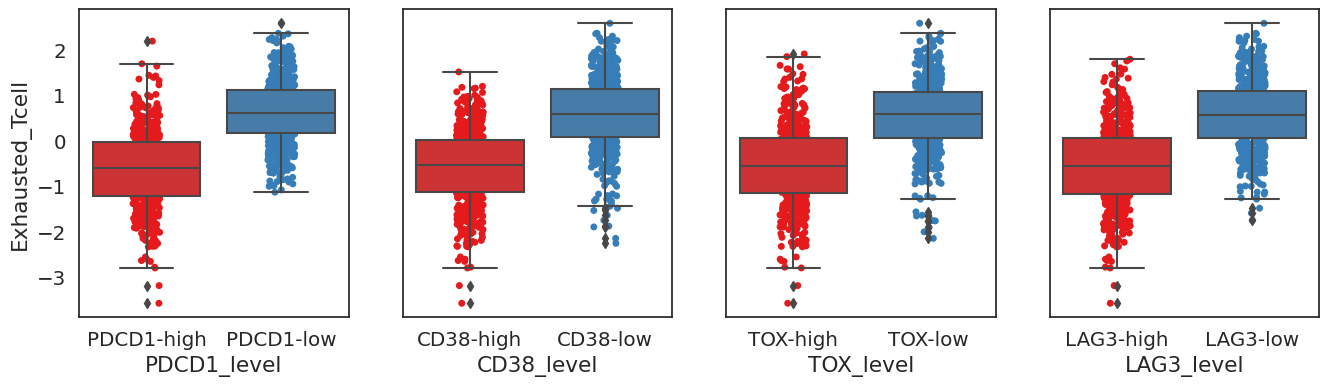

In [22]:

fig, axes=plt.subplots(figsize=(16,4),  nrows=1, ncols=4, sharey=True)

for y,ax in zip(['PDCD1', 'CD38', 'TOX', 'LAG3'], axes):
    dfp = dfcelltype[['Exhausted_Tcell']].join(np.log10(dfcx[y]+1))
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
    dfp = scaler.fit_transform(dfp)
    median_value = dfp[y].median()
    # Create a new column 'CD38_category' to categorize the rows as 'CD38-high' or 'CD38-low'
    dfp['%s_level' % y] = ['%s-high' % y if x >= median_value else '%s-low' % y for x in dfp[y]]

    sns.stripplot(data = dfp, x='%s_level' % y, y = 'Exhausted_Tcell', order = ['%s-high' % y, '%s-low' % y], ax=ax, zorder = 0.5, palette='Set1')
    sns.boxplot(data = dfp, x='%s_level' % y, y = 'Exhausted_Tcell', order = ['%s-high' % y, '%s-low' % y], ax=ax, palette='Set1')


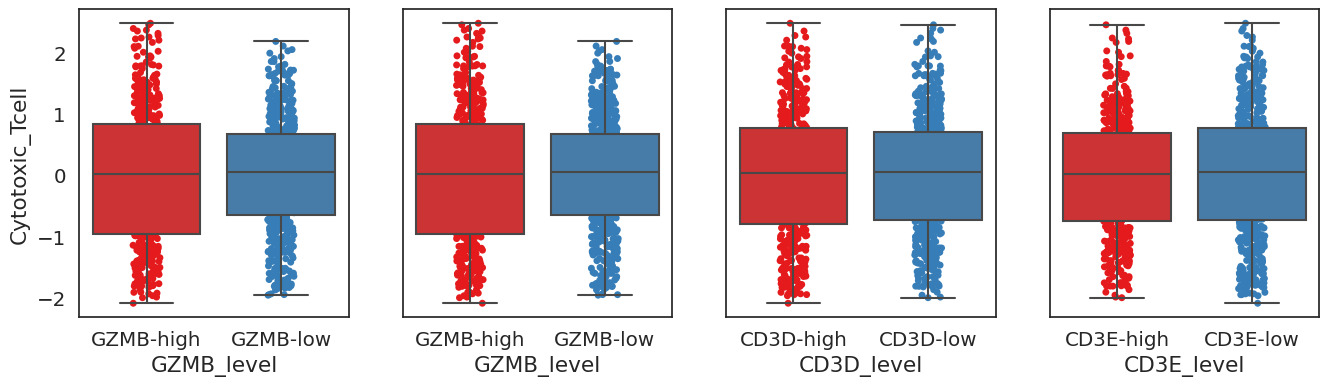

In [21]:

fig, axes=plt.subplots(figsize=(16,4),  nrows=1, ncols=4, sharey=True)

for y,ax in zip(['GZMB', 'GZMB','CD3D', 'CD3E' ], axes): #['GZMA', 'GZMB', 'PRF1', 'KLRB1']
    dfp = dfcelltype[['Cytotoxic_Tcell']].join(np.log10(dfcx_norm[y]+1))
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
    dfp = scaler.fit_transform(dfp)
    median_value = dfp[y].median()
    # Create a new column 'CD38_category' to categorize the rows as 'CD38-high' or 'CD38-low'
    dfp['%s_level' % y] = ['%s-high' % y if x >= median_value else '%s-low' % y for x in dfp[y]]
    
    sns.stripplot(data = dfp, x='%s_level' % y, y = 'Cytotoxic_Tcell', order = ['%s-high' % y, '%s-low' % y], ax=ax, zorder = 0.5, palette='Set1')
    sns.boxplot(data = dfp, x='%s_level' % y, y = 'Cytotoxic_Tcell', order = ['%s-high' % y, '%s-low' % y], ax=ax, palette='Set1')


Text(0, 0.5, "Exhausted_Tcell's score")

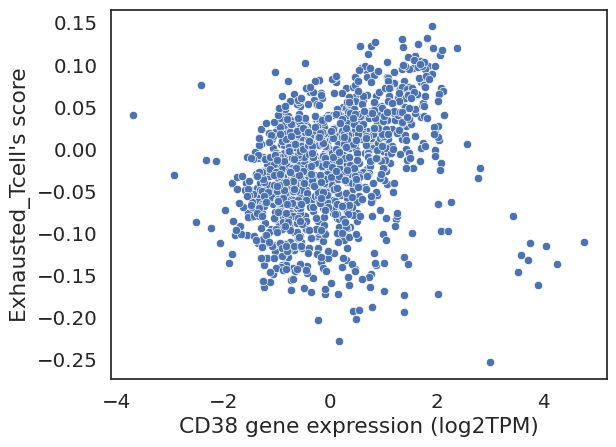

In [11]:
y = 'PDCD1'
dfp = dfcelltype[['Exhausted_Tcell']].join(dfcx_norm[y])
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Exhausted_Tcell', ax=ax)
ax.set_xlabel('CD38 gene expression (log2TPM)')
ax.set_ylabel("Exhausted_Tcell's score")

Text(0, 0.5, "Exhausted_Tcell's score")

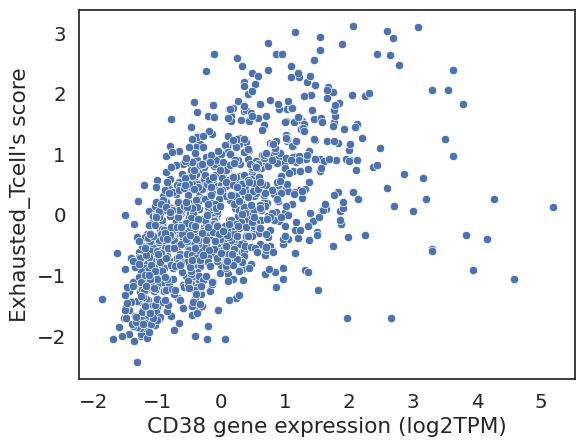

In [172]:
y = 'PDCD1'
dfp = dfcx_norm[['GZMB']].join(dfcx_norm[y])

#dfp = np.log10(dfp+1)
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'GZMB', ax=ax)
ax.set_xlabel('CD38 gene expression (log2TPM)')
ax.set_ylabel("Exhausted_Tcell's score")

Text(0, 0.5, "Cytotoxic_Tcell's score")

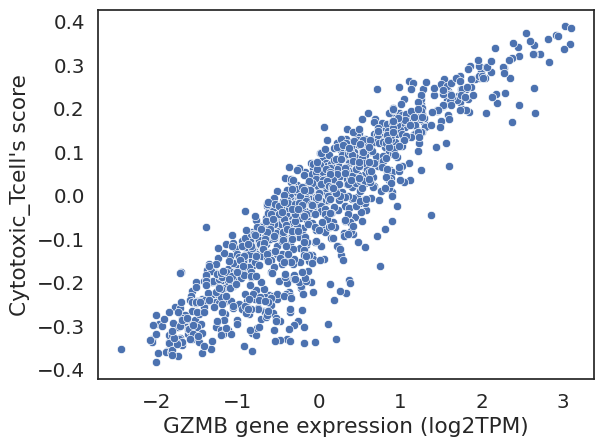

In [173]:
y = 'GZMB'
dfp = dfcelltype[['Cytotoxic_Tcell']].join(dfcx_norm[y])
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Cytotoxic_Tcell', ax=ax)
ax.set_xlabel('GZMB gene expression (log2TPM)')
ax.set_ylabel("Cytotoxic_Tcell's score")

In [176]:
# expression = np.log2(df_tpm + 1)
# df_tpm_norm = expression.apply(lambda v: v-v.mean(),axis=1)

Text(0, 0.5, "PD1's score in Compass")

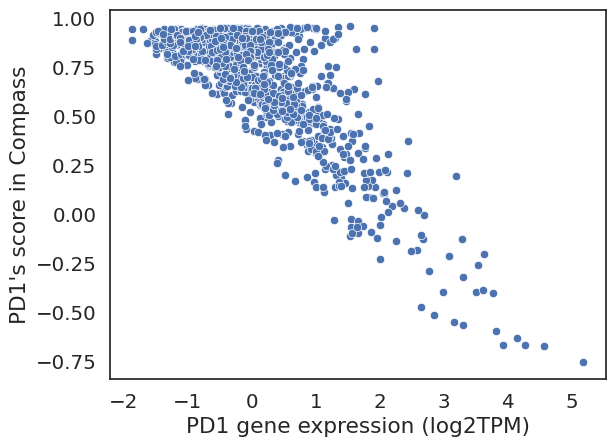

In [177]:
y = 'PDCD1'
#dfgeneset[['Target_marker_PD1']].join(np.log10(dfcx_norm[y]+1)).corr()
dfp = dfgeneset[['Target_marker_PD1']].join(dfcx_norm[y])
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Target_marker_PD1', ax=ax)
ax.set_xlabel('PD1 gene expression (log2TPM)')
ax.set_ylabel("PD1's score in Compass")

Text(0, 0.5, "Exhausted_Tcell's score")

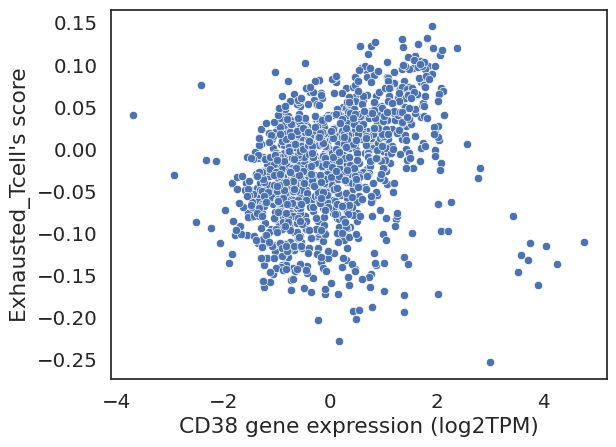

In [88]:
y = 'PDCD1'
dfp = dfcelltype[['Exhausted_Tcell']].join(dfcx_norm[y])
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Exhausted_Tcell', ax=ax)
ax.set_xlabel('CD38 gene expression (log2TPM)')
ax.set_ylabel("Exhausted_Tcell's score")

Text(0, 0.5, "Cytotoxic_Tcell's score")

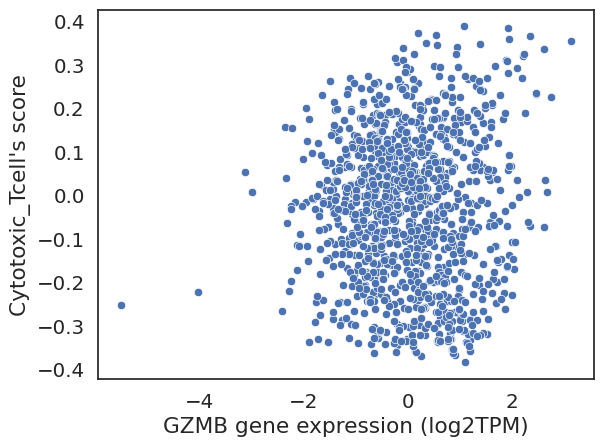

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:7.712e-08 U_stat=5.752e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:3.456e-02 U_stat=2.825e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:7.214e-04 U_stat=2.873e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:4.863e-10 U_stat=6.045e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:5.114e-01 U_stat=3.714e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val

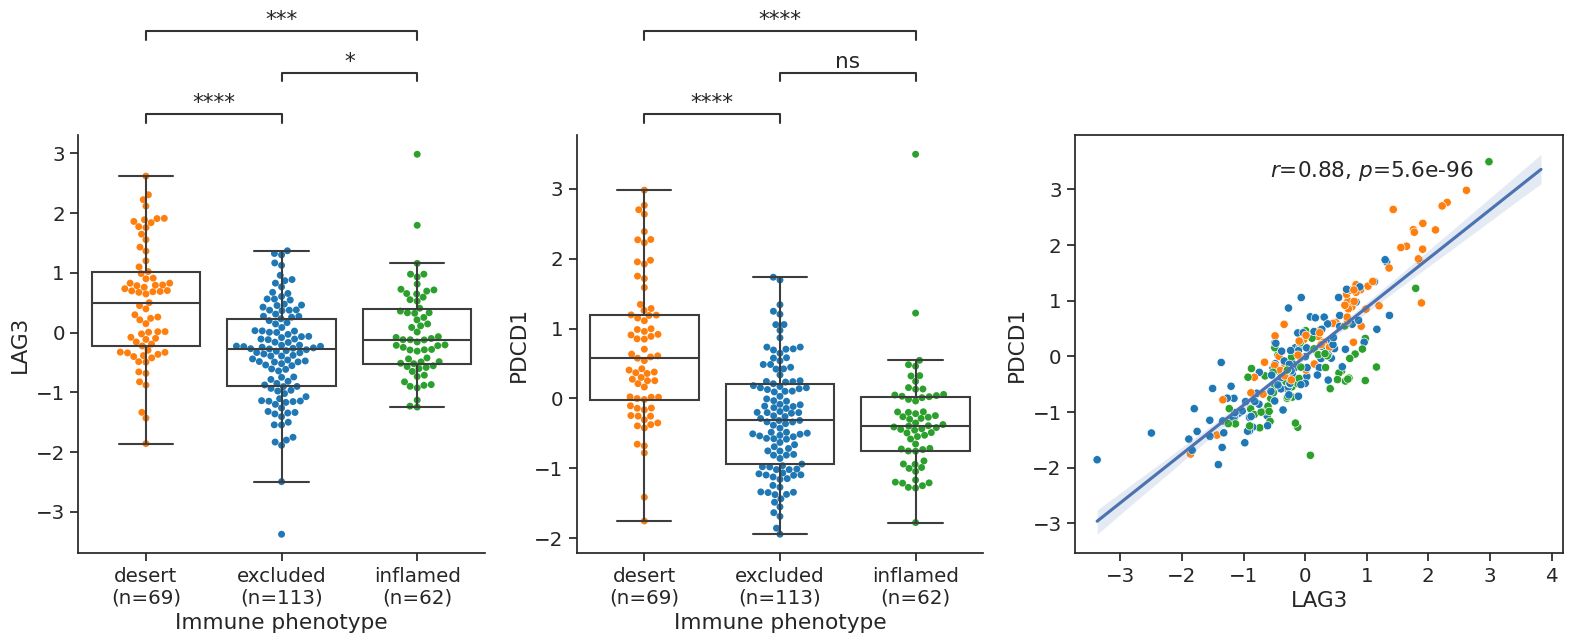

In [93]:
IMVigor210 = df_label[df_label.cohort == 'IMVigor210']

x = 'Immune phenotype'
y1 = 'LAG3'
y2 = 'PDCD1'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]

raw_x = dfcx_norm[[y1, y2]]


data = IMVigor210[[x]].join(raw_x)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
data[[y1, y2]] = scaler.fit_transform(data[[y1, y2]])


size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

fig.tight_layout()

#fig.savefig('IMvigor210_score_phenotype.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:3.504e-11 U_stat=1.614e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.932e-05 U_stat=2.163e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:8.150e-15 U_stat=4.540e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:4.721e-12 U_stat=1.514e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.281e-07 U_stat=1.810e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val

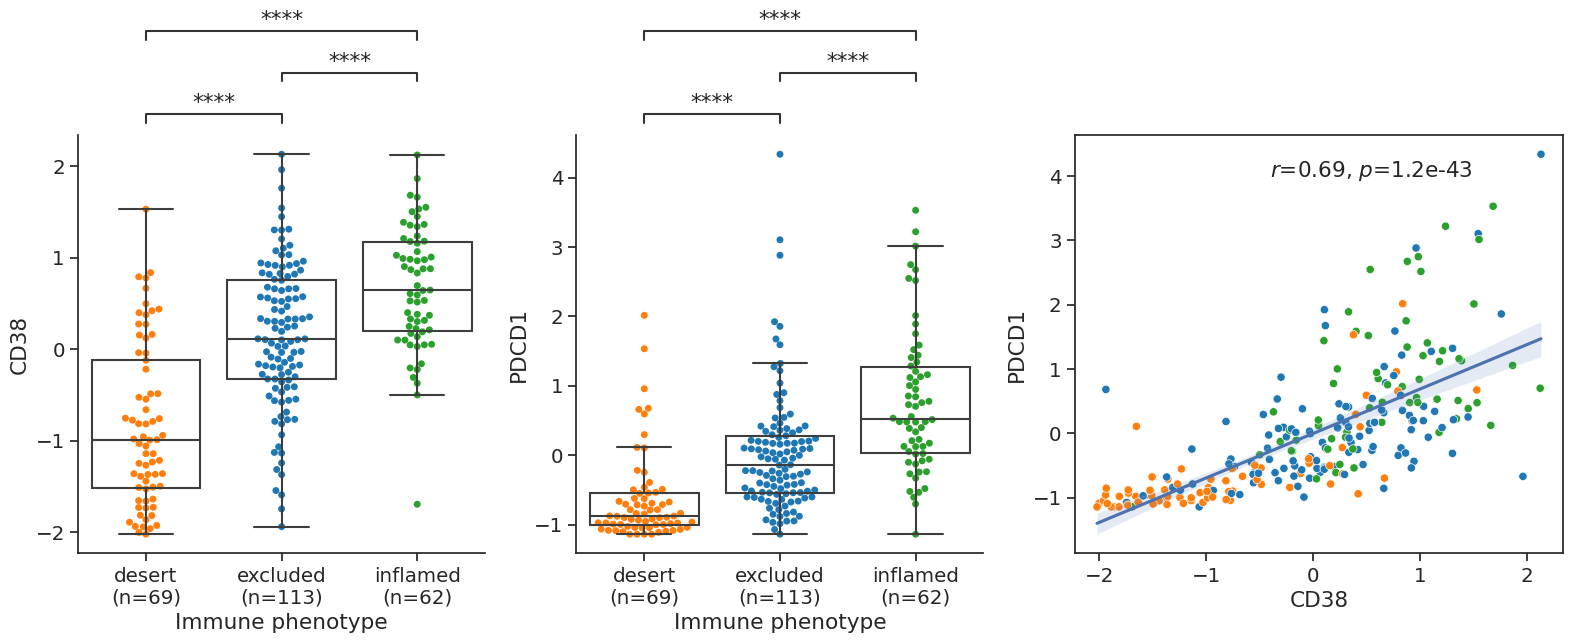

In [92]:
IMVigor210 = df_label[df_label.cohort == 'IMVigor210']

x = 'Immune phenotype'
y1 = 'CD38'
y2 = 'PDCD1'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]

raw_x = np.log10(dfcx[[y1, y2]]+1)


data = IMVigor210[[x]].join(raw_x)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
data[[y1, y2]] = scaler.fit_transform(data[[y1, y2]])


size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

fig.tight_layout()

#fig.savefig('IMvigor210_score_phenotype.pdf')

Text(0, 0.5, "Cytotoxic_Tcell's score")

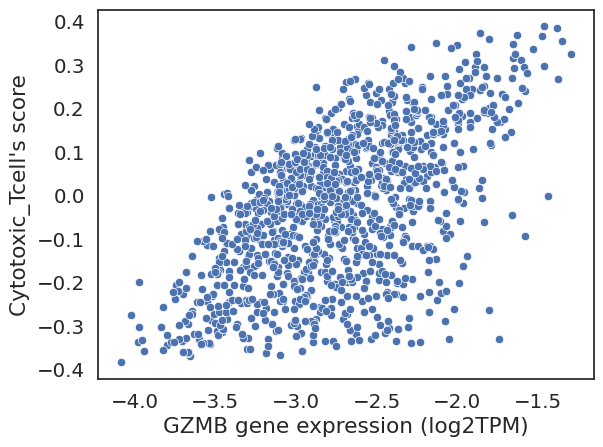

In [89]:
y = 'GZMB'
new = np.log10((dfcx[y]+1) / (dfcx['ACTB']+1))
new = new.to_frame(name = y)

#new = np.log10((dfcx[y]+1) )
dfp = dfcelltype[['Cytotoxic_Tcell']].join(new)
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Cytotoxic_Tcell', ax=ax)
ax.set_xlabel('GZMB gene expression (log2TPM)')
ax.set_ylabel("Cytotoxic_Tcell's score")

In [128]:
dfcelltype.columns

Index(['CANCER', 'Bcell_general', 'Memory_Bcell', 'Naive_Bcell', 'Plasma_cell',
       'CD4_Tcell', 'CD8_Tcell', 'Memory_Tcell', 'Naive_Tcell',
       'Tcell_general', 'Cytotoxic_Tcell', 'Exhausted_Tcell',
       'Immune_checkpoint', 'Treg', 'NKcell', 'Innate_lymphoid_cell', 'cDC',
       'pDC', 'Macrophage', 'Monocyte', 'Myeloid', 'Granulocyte', 'Mast',
       'Erythrocyte', 'Platelet', 'Stem', 'Stroma', 'Pericyte', 'Fibroblast',
       'Endothelial', 'Epithelial', 'Mesothelial', 'Adipocyte', 'Hepatocyte',
       'Pancreatic', 'Pneumocyte', 'Apoptosis_pathway', 'IFNg_pathway',
       'TGFb_pathway', 'Cytokine', 'Cell_proliferation', 'TLS',
       'Genome_integrity', 'Reference'],
      dtype='object')

In [114]:
np.log10(dfcx[[a]]+1).join(np.log10(y+1)).corr()

,CD38,CD38_norm
CD38,1.000000,0.223152
CD38_norm,0.223152,1.000000


In [89]:


y1 = np.log10(dfcx[b]+1)
y2 = np.log10(dfcx[a]+1)

y = y1/y2
y = y.to_frame(name = '%s_norm' % b)
y

,PDCD1_norm
Index,
IMVigor210-0257bb-ar-0257bbb,0.065952
IMVigor210-025b45-ar-025b45c,0.039581
IMVigor210-032c64-ar-032c642,0.224430
IMVigor210-0571f1-ar-0571f17,0.382866
IMVigor210-065890-ar-0658907,0.071082
...,...
Kim_NatMed_2018-p664-ar-026,0.237048
Kim_NatMed_2018-p666-ar-029,0.270673
Kim_NatMed_2018-p667-ar-030,0.171208


In [90]:
dfgeneset[['Target_marker_PD1']].join(y).corr()

,Target_marker_PD1,PDCD1_norm
Target_marker_PD1,1.00000,-0.70114
PDCD1_norm,-0.70114,1.00000


In [91]:
dfcelltype[['Exhausted_Tcell']].join(y).corr()

,Exhausted_Tcell,PDCD1_norm
Exhausted_Tcell,1.000000,-0.353869
PDCD1_norm,-0.353869,1.000000


In [87]:
dfgeneset[['Target_marker_PD1']].join(np.log10(dfcx[b]+1)).corr()

,Target_marker_PD1,PDCD1
Target_marker_PD1,1.000000,-0.994185
PDCD1,-0.994185,1.000000


Text(0, 0.5, "PD1's score in Compass")

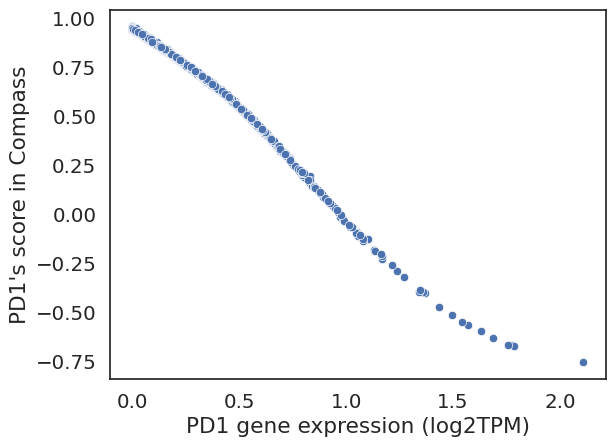

In [67]:
y = 'PDCD1'
dfgeneset[['Target_marker_PD1']].join(np.log10(dfcx[y]+1)).corr()
dfp = dfgeneset[['Target_marker_PD1']].join(np.log10(dfcx[y]+1))
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = 'PDCD1', y = 'Target_marker_PD1', ax=ax)
ax.set_xlabel('PD1 gene expression (log2TPM)')
ax.set_ylabel("PD1's score in Compass")

Text(0, 0.5, "PD-L1's score in Compass")

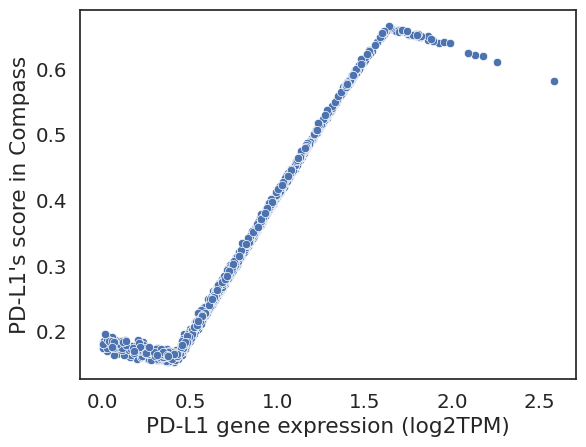

In [62]:
y = 'CD274'
dfgeneset[['Target_marker_PDL1']].join(np.log10(dfcx[y]+1)).corr()
dfp = dfgeneset[['Target_marker_PDL1']].join(np.log10(dfcx[y]+1))
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Target_marker_PDL1', ax=ax)
ax.set_xlabel('PD-L1 gene expression (log2TPM)')
ax.set_ylabel("PD-L1's score in Compass")

Text(0, 0.5, "CTLA4's score in Compass")

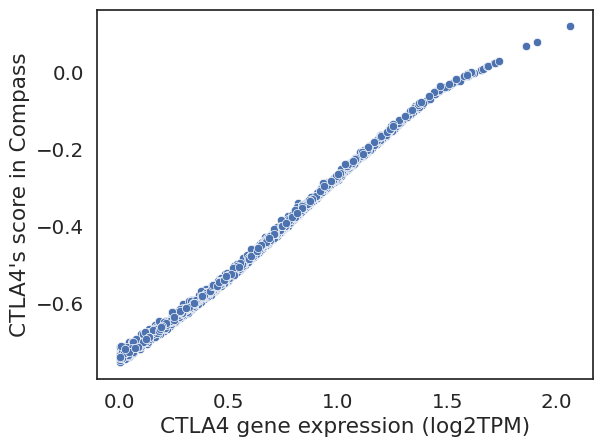

In [63]:
y = 'CTLA4'
dfgeneset[['Target_marker_CTLA4']].join(np.log10(dfcx[y]+1)).corr()
dfp = dfgeneset[['Target_marker_CTLA4']].join(np.log10(dfcx[y]+1))
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Target_marker_CTLA4', ax=ax)
ax.set_xlabel('CTLA4 gene expression (log2TPM)')
ax.set_ylabel("CTLA4's score in Compass")

Text(0, 0.5, "Exhausted_Tcell's score")

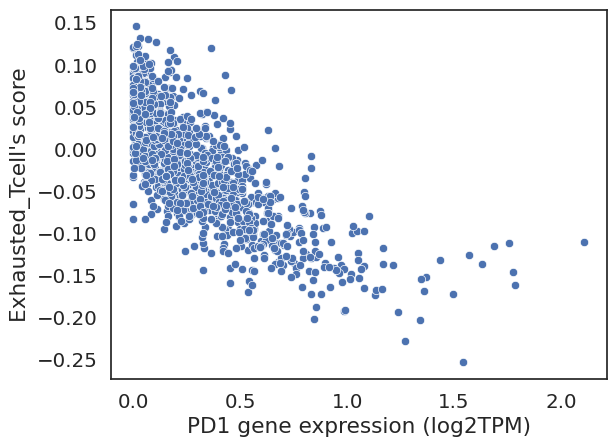

In [64]:
y = 'PDCD1'
dfp = dfcelltype[['Exhausted_Tcell']].join(np.log10(dfcx[y]+1))
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Exhausted_Tcell', ax=ax)
ax.set_xlabel('PD1 gene expression (log2TPM)')
ax.set_ylabel("Exhausted_Tcell's score")

Text(0, 0.5, "Exhausted_Tcell's score")

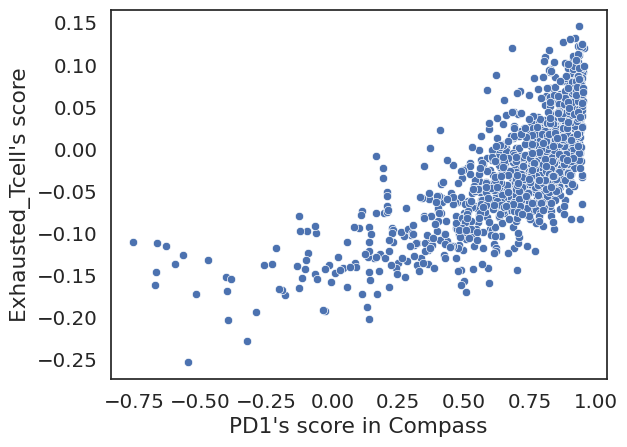

In [65]:
y = 'Target_marker_PD1'
dfp = dfcelltype[['Exhausted_Tcell']].join(dfgeneset[['Target_marker_PD1']])
fig,ax = plt.subplots()

sns.scatterplot(data = dfp, x = y, y = 'Exhausted_Tcell', ax=ax)
ax.set_xlabel("PD1's score in Compass")
ax.set_ylabel("Exhausted_Tcell's score")

Text(0, 0.5, 'PD1 gene expression (log2TPM)')

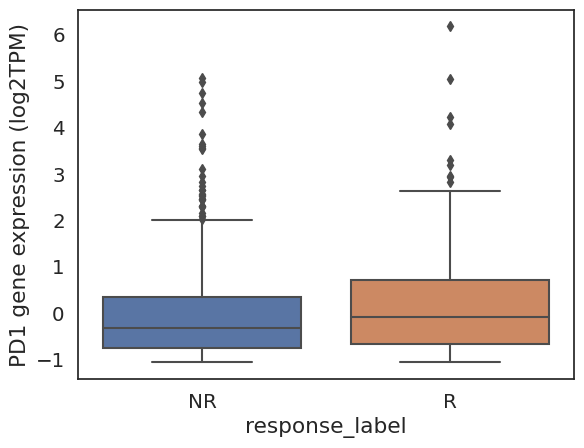

In [50]:
y = 'PDCD1'
dfp = dfgeneset[['Target_marker_PD1']].join(np.log10(dfcx[y]+1))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
dfp = scaler.fit_transform(dfp)

dfp = dfp.join(df_label.response_label)

# median_value = dfp[y].median()
# # Create a new column 'CD38_category' to categorize the rows as 'CD38-high' or 'CD38-low'
# dfp['%s_level' % y] = ['%s-high' % y if x >= median_value else '%s-low' % y for x in dfp[y]]

fig, ax=plt.subplots()
sns.boxplot(data = dfp, x='response_label', y = y, ax=ax) #order = ['%s-high' % y, '%s-low' % y], 
ax.set_ylabel('PD1 gene expression (log2TPM)')

Text(0, 0.5, "PD1's score in Compass")

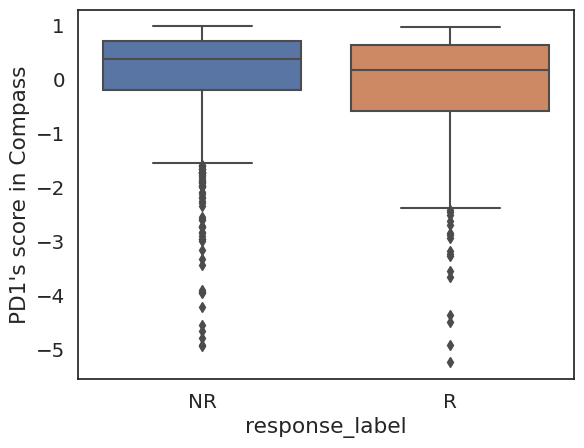

In [53]:
y = 'PDCD1'
dfp = dfgeneset[['Target_marker_PD1']].join(np.log10(dfcx[y]+1))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
dfp = scaler.fit_transform(dfp)

dfp = dfp.join(df_label.response_label)

# median_value = dfp[y].median()
# # Create a new column 'CD38_category' to categorize the rows as 'CD38-high' or 'CD38-low'
# dfp['%s_level' % y] = ['%s-high' % y if x >= median_value else '%s-low' % y for x in dfp[y]]

fig, ax=plt.subplots()
sns.boxplot(data = dfp, x='response_label', y = 'Target_marker_PD1', ax=ax) #order = ['%s-high' % y, '%s-low' % y], 
ax.set_ylabel("PD1's score in Compass")

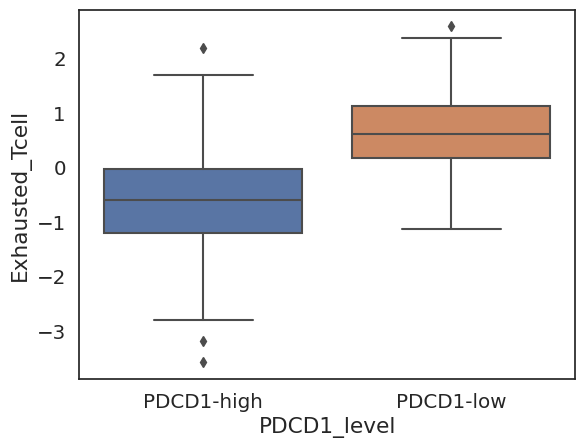

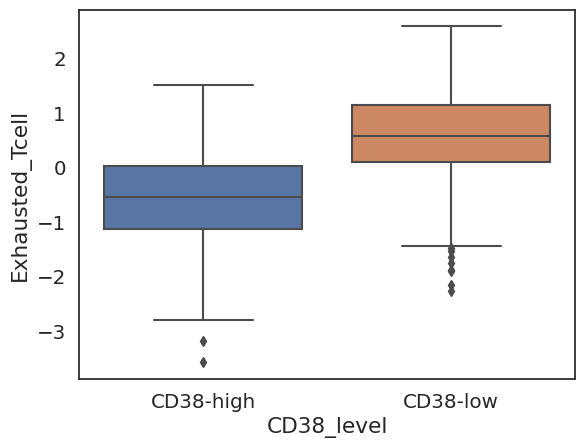

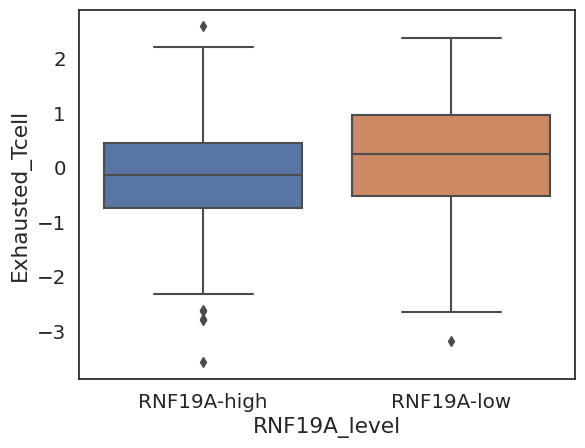

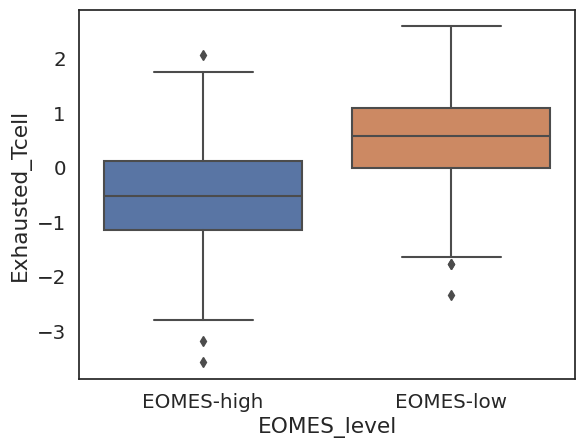

In [6]:
y = 'PDCD1'

for y in ['PDCD1', 'CD38', 'RNF19A', 'EOMES']:
    dfp = dfcelltype[['Exhausted_Tcell']].join(np.log10(dfcx[y]+1))
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
    dfp = scaler.fit_transform(dfp)
    median_value = dfp[y].median()
    # Create a new column 'CD38_category' to categorize the rows as 'CD38-high' or 'CD38-low'
    dfp['%s_level' % y] = ['%s-high' % y if x >= median_value else '%s-low' % y for x in dfp[y]]

    fig, ax=plt.subplots()
    sns.boxplot(data = dfp, x='%s_level' % y, y = 'Exhausted_Tcell', order = ['%s-high' % y, '%s-low' % y], ax=ax)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:7.744e-09 U_stat=5.890e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.584e-07 U_stat=5.184e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:4.412e-17 U_stat=3.962e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:1.249e-11 U_stat=1.562e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:7.721e-11 U_stat=1.417e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val

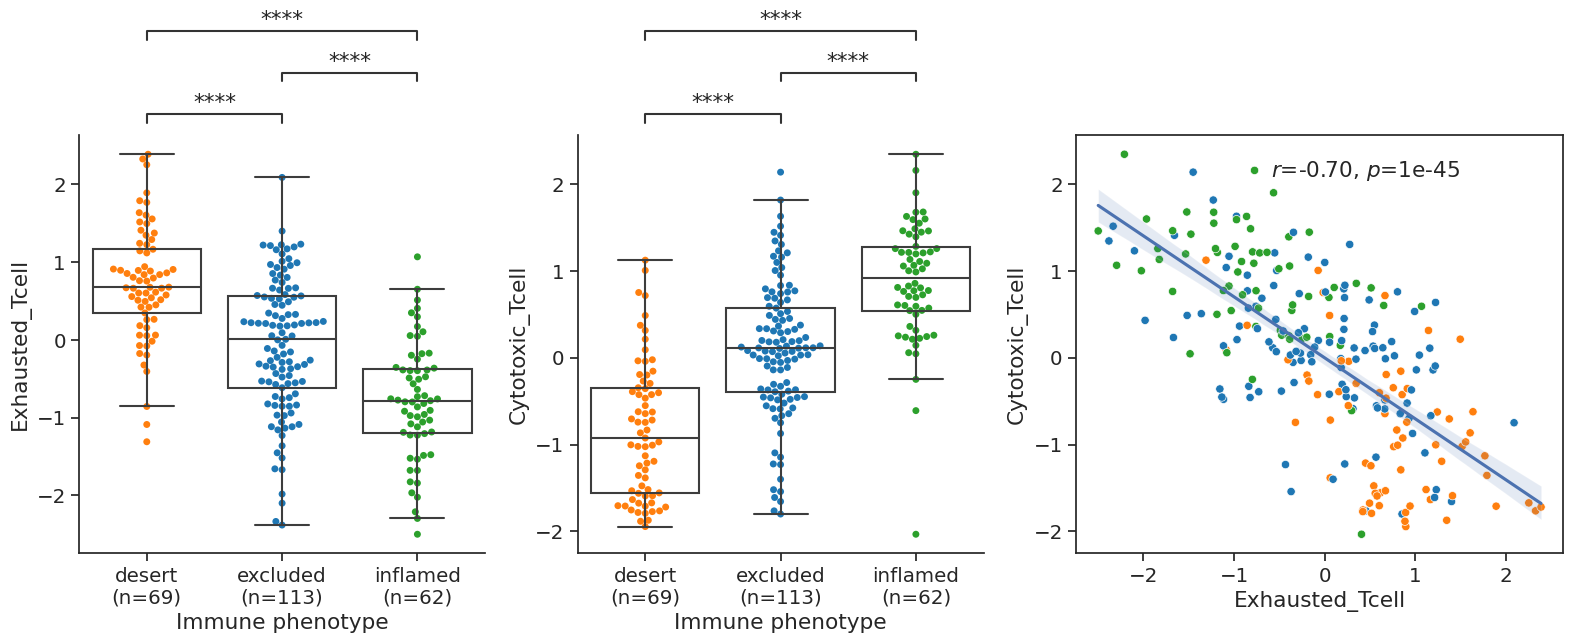

In [7]:
IMVigor210 = df_label[df_label.cohort == 'IMVigor210']

x = 'Immune phenotype'
y1 = 'Exhausted_Tcell'
y2 = 'Cytotoxic_Tcell'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]
data = IMVigor210[[x]].join(dfcelltype[[y1,y2]])


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
data[[y1, y2]] = scaler.fit_transform(data[[y1, y2]])


size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    # ax.set_xticklabels(
    #     x_order, 
    #     rotation=1, 
    #     ha="right",  
    #     rotation_mode="anchor")  # <====== HERE is the ke

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)


    
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
# ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
# ax3.xaxis.set_major_locator(ticker.MultipleLocator(0.1))


fig.tight_layout()

#fig.savefig('IMvigor210_score_phenotype.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:3.504e-11 U_stat=1.614e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.932e-05 U_stat=2.163e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:8.150e-15 U_stat=4.540e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:5.974e-03 U_stat=2.950e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.590e-05 U_stat=2.154e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val

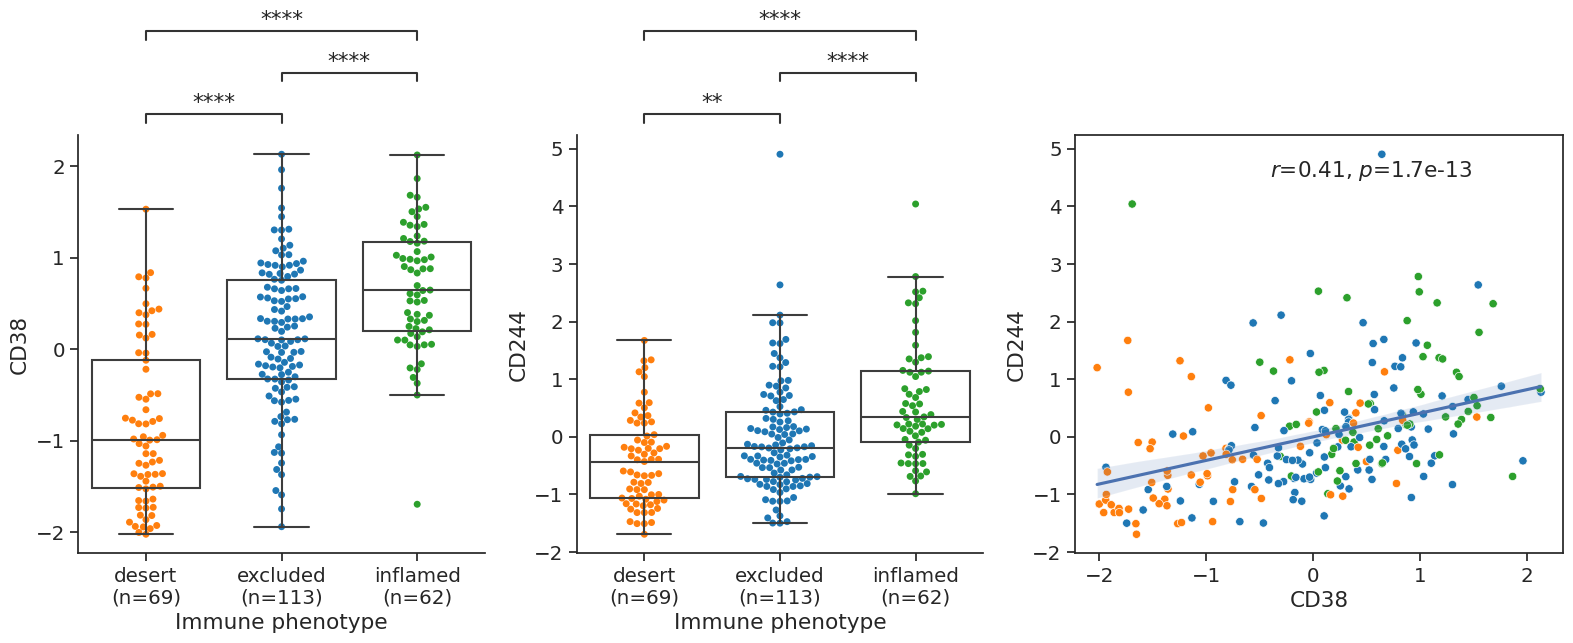

In [14]:
IMVigor210 = df_label[df_label.cohort == 'IMVigor210']

x = 'Immune phenotype'
y1 = 'CD38'
y2 = 'CD244'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]

raw_x = np.log10(dfcx[[y1, y2]]+1)


data = IMVigor210[[x]].join(raw_x)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
data[[y1, y2]] = scaler.fit_transform(data[[y1, y2]])


size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

fig.tight_layout()

#fig.savefig('IMvigor210_score_phenotype.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:9.516e-09 U_stat=1.919e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.477e-13 U_stat=1.156e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:1.285e-18 U_stat=2.280e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:6.673e-07 U_stat=2.184e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:6.999e-03 U_stat=2.638e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val

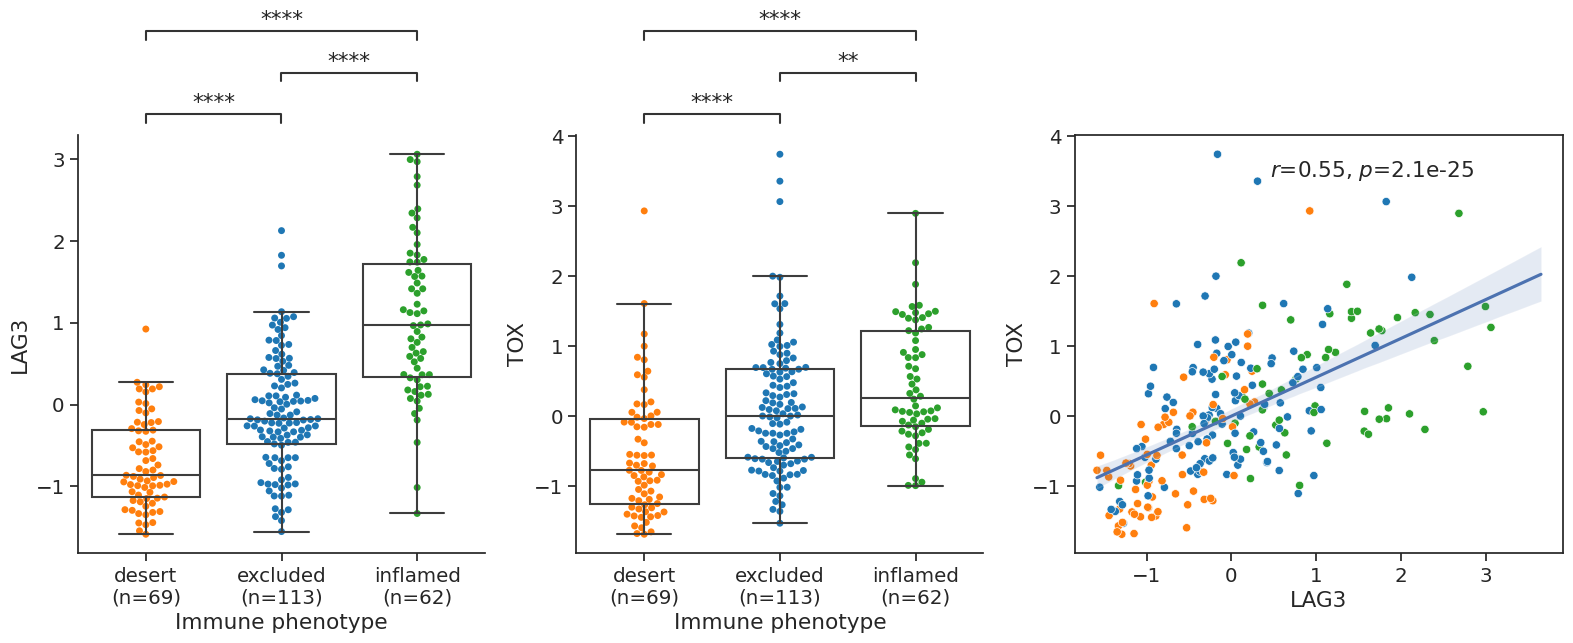

In [16]:
IMVigor210 = df_label[df_label.cohort == 'IMVigor210']

x = 'Immune phenotype'
y1 = 'LAG3'
y2 = 'TOX'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]

raw_x = np.log10(dfcx[[y1, y2]]+1)


data = IMVigor210[[x]].join(raw_x)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
data[[y1, y2]] = scaler.fit_transform(data[[y1, y2]])


size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

fig.tight_layout()

#fig.savefig('IMvigor210_score_phenotype.pdf')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:3.504e-11 U_stat=1.614e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.932e-05 U_stat=2.163e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:8.150e-15 U_stat=4.540e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

desert
(n=69) vs. excluded
(n=113): Mann-Whitney-Wilcoxon test two-sided, P_val:3.115e-11 U_stat=1.608e+03
excluded
(n=113) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val:2.976e-10 U_stat=1.483e+03
desert
(n=69) vs. inflamed
(n=62): Mann-Whitney-Wilcoxon test two-sided, P_val

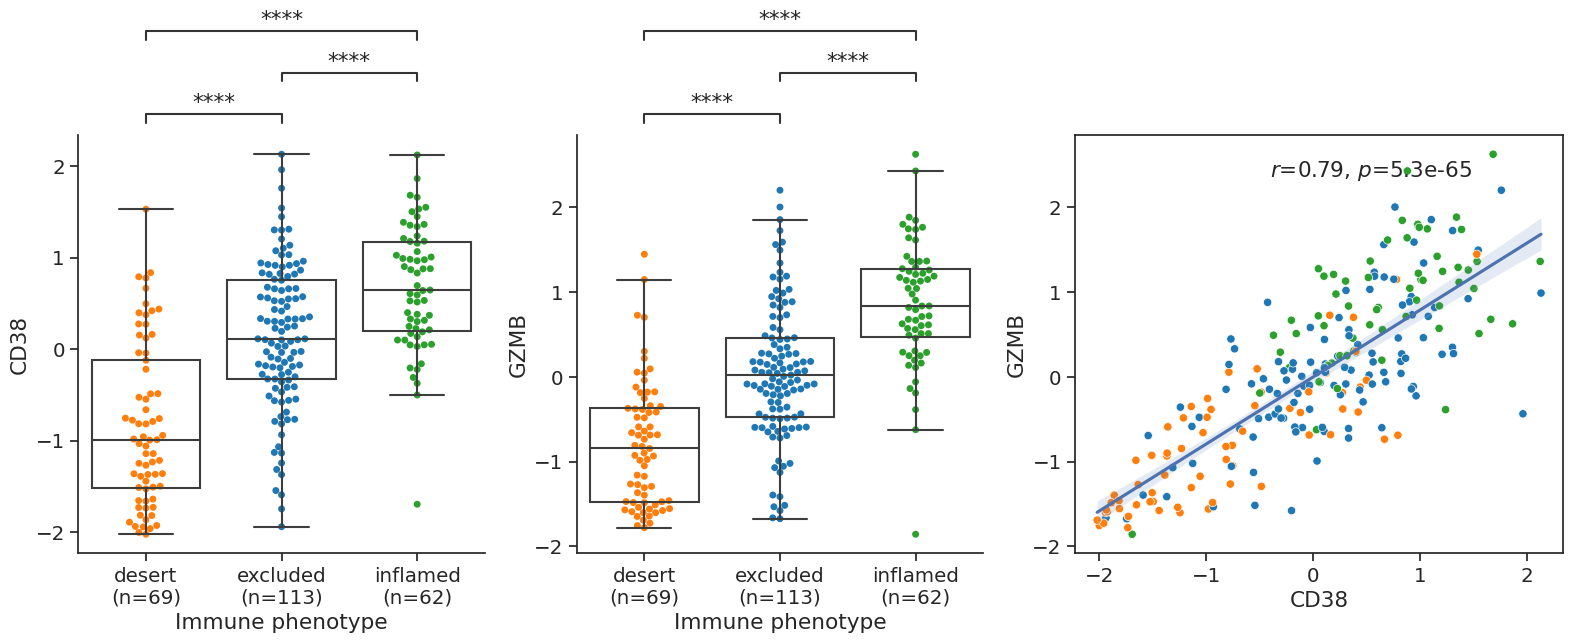

In [13]:
IMVigor210 = df_label[df_label.cohort == 'IMVigor210']

x = 'Immune phenotype'
y2 = 'GZMB'
y1 = 'CD38'
x_order = ['desert', 'excluded', 'inflamed']
box_pairs = [('desert', 'excluded'), ('desert', 'inflamed'), ('excluded', 'inflamed')]

raw_x = np.log10(dfcx[[y1, y2]]+1)


data = IMVigor210[[x]].join(raw_x)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform='pandas') # set_output works from version 1.2
data[[y1, y2]] = scaler.fit_transform(data[[y1, y2]])


size = data.groupby(x).size()
size = size.index + "\n(n=" + size.astype(str) + ')'
phenotype_map = size.to_dict()
data[x] = data[x].map(phenotype_map)
x_order = pd.Series(x_order).map(phenotype_map).tolist()

box_pairs = [(x_order[i], x_order[j]) for i in range(len(x_order)) for j in range(i+1, len(x_order))]



import scipy
from statannotations.Annotator import Annotator
def annotate(ax, data, x, y):
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=data[x], y=data[y])
    ax.text(.4, .9, f'$r$={rvalue:.2f}, $p$={pvalue:.2g}', transform=ax.transAxes)
    

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16, 7), ncols=3, width_ratios = [1,1,1.2])

palette = sns.palettes.color_palette('tab10', 4)
palette = [palette[1], palette[0], palette[2]]


sns.boxplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})
sns.boxplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2, width = .8, palette = palette, fliersize=0,  boxprops={'facecolor':'None'})

sns.swarmplot(data = data, x = x, y = y2, 
            order = x_order, ax=ax2,  palette = palette,  zorder=.5)

sns.swarmplot(data = data, x = x, y = y1, 
            order = x_order, ax=ax1,  palette = palette, zorder=.5)


annotator = Annotator(ax1, pairs=box_pairs, data=data, x=x, y=y1, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()

annotator = Annotator(ax2, pairs=box_pairs, data=data, x=x, y=y2, order=x_order)
annotator.configure(test='Mann-Whitney', text_format='star',  loc='outside', comparisons_correction = None,)
annotator.apply_and_annotate()


sns.scatterplot(data = data, x = y1, y = y2,  hue = x, ax=ax3, legend = False, 
                palette = palette, hue_order = x_order)
sns.regplot(data=data, x=y1, y=y2, scatter=False, ax=ax3)
annotate(ax3, data, y1, y2)

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax3.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)

fig.tight_layout()

#fig.savefig('IMvigor210_score_phenotype.pdf')